In [1]:
import numpy as np
import math
import time
from datetime import datetime

import torch
import torch.nn as nn
import torchvision.transforms as transform

import audioDataloader.dataloader as dataloader
from audioDataloader.transforms import mulawnEncode,mulaw,array2tensor,dic2tensor,injectNoise,normalizeDim
from paramManager import paramManager

import matplotlib.pylab as plt
%matplotlib inline

In [2]:
# Some utility functions
#*************************************
def time_taken(elapsed):
    """To format time taken in hh:mm:ss. Use with time.monotic()"""
    m, s = divmod(elapsed, 60)
    h, m = divmod(m, 60)
    return "%d:%02d:%02d" % (h, m, s)

def mydate() :
    return (datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

In [4]:
# Read/write directory parameters
#*************************************
datadir = 'data/synth64_76/dataset'
paramdir = 'data/synth64_76/dataparams'
savemodeldir = 'model'
loadmodelpath = 'model/2018-10-12_20-14-50_model_epoch1_step2100.pth'

# Pytorch parameters
#*************************************
#--- Note all intervals below are counted in no. of steps. 1 epoch = [len(dataset)//batch_size] steps ---

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
savemodel = True
savemodel_interval = 0  #if 0 (and savemodel=True) will only save model at the end of entire training
loadmodel = False

# Training parameters
#*************************************
sr = 16000
seqLen = 256
stride = 10
batch_size = 256
num_epochs = 1
lr = 0.005
log_interval = 5
max_steps = 1000 #set max_steps > (len(dataset)//batch_size) if training for more than 1 epoch
teacher_forcing_ratio = 1 #stochastically use either targets or own predictions as input for training. Set to 1 to always use targets

#Generation parameters
#*************************************
max_length = seqLen*3
evaluate_interval = 100

print(device, torch.version.cuda)

cuda:0 9.0


In [5]:
# Let's check out the available conditional parameters first
#*************************************
pm = paramManager.paramManager(datadir, paramdir)
datafiles = pm.filenames(datadir)
params = pm.getParams(datafiles[0]) 
print(params.keys())

#note midiPitch has to be scaled since the large raw values interfere with the learning

dict_keys(['meta', 'instID', 'amplitude', 'midiPitch'])


In [6]:
# Initialize dataset & dataloader
#*************************************
audiocoding = mulawnEncode(256,0,1) #initialize the mu-law encodings
targetcoding = mulaw(256)
rescalePitch = normalizeDim('midiPitch',64,76)
rescaleAmp = normalizeDim('amplitude',0,0.9)

adataset = dataloader.AudioDataset(sr,seqLen,stride,
                                  datadir=datadir,extension='wav',
                                  paramdir=paramdir,prop=['instID','amplitude','midiPitch'],
                                  transform=transform.Compose([injectNoise(weight=0.1),audiocoding,array2tensor(torch.FloatTensor)]),
                                  param_transform=transform.Compose([rescaleAmp,rescalePitch,dic2tensor(torch.FloatTensor)]),
                                  target_transform=transform.Compose([targetcoding,array2tensor(torch.LongTensor)]))

testdataset = dataloader.AudioDataset(sr,seqLen,stride,
                                  datadir=datadir,extension='wav',
                                  paramdir=paramdir,prop=['instID','amplitude','midiPitch'],
                                  transform=transform.Compose([array2tensor(torch.FloatTensor)]), 
                                  param_transform=transform.Compose([rescaleAmp,rescalePitch,dic2tensor(torch.FloatTensor)]),
                                  target_transform=transform.Compose([array2tensor(torch.LongTensor)]))

train_loader = torch.utils.data.DataLoader(dataset=adataset,
                                           batch_size=batch_size, 
                                           shuffle=True,
                                           num_workers=4,
                                           drop_last=True)

test_loader = torch.utils.data.DataLoader(dataset=testdataset,
                                          batch_size=1, 
                                          shuffle=True,
                                          num_workers=4,
                                          drop_last=True)

size of dataset is 1248000
no. of steps per epoch is 4875
(256, 1)


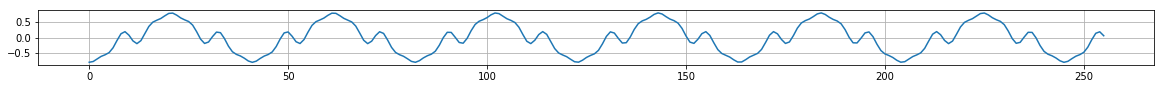

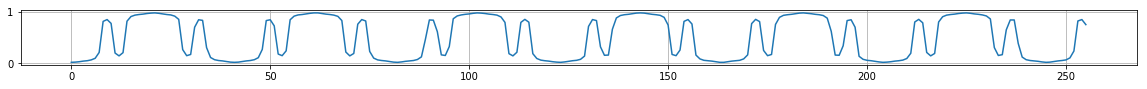

In [8]:
print("size of dataset is",len(adataset))
print("no. of steps per epoch is",len(adataset)//batch_size)

samp = adataset.rand_sample()
print(samp.shape)
plt.figure(figsize=(20,1)) 
plt.plot(np.arange(len(samp)), samp) #just print one example from the batch
plt.grid()
plt.show()

samp = audiocoding(samp)
plt.figure(figsize=(20,1)) 
plt.plot(np.arange(len(samp)), samp) #just print one example from the batch
plt.grid()
plt.show()

In [9]:
# Specify the model
#*************************************
class RNN(nn.Module):
    # input size - the number of "classes"
    def __init__(self, input_size, cond_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.cond_size = cond_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers #no. of stacked GRU layers

        self.i2h = nn.Linear(input_size+cond_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, batch_first=True)
        self.decoder = nn.Linear(hidden_size, output_size)
    

    # input and cv are each one sequence element 
    def forward(self, input, hidden, batch_size=1):
        #print("input size is " + str((input.size())))
        
        h1 = self.i2h(input)
        #print("size of h1 is " + str(h1.size()))
        
        h_out, hidden = self.gru(h1.view(batch_size,1,-1), hidden)
        #print("h_out"+str(h_out.size()))
        
        output = self.decoder(h_out.view(batch_size,-1))
        #print("output2"+str(output.size()))
        
        return output, hidden

    # initialize hiddens for each minibatch
    def init_hidden(self,batch_size=1):
        return torch.zeros(self.n_layers, batch_size, self.hidden_size, dtype=torch.float, device=device)

In [10]:
# Define the training cycle (100% teacher forcing for now)
#*************************************
def train(model,epoch):
    model.train() #put in training mode
    ave_loss_over_steps = 0
    
    for step, (inp,target) in enumerate(train_loader):
        inp, target = inp.to(device), target.to(device)
        #print(inp.shape)

        # Forward + Backward + Optimize
        hidden = model.init_hidden(batch_size)
        optimizer.zero_grad()
        loss = 0
        
        for i in range(seqLen):
            use_teacher_forcing = True if np.random.random() < teacher_forcing_ratio or i==0 else False
            #similar to Bengio et al, Scheduled Sampling for Sequence Prediction with Recurrent Neural Networks
            
            if use_teacher_forcing: #feed the target as the next input 
                outputs, hidden = model(inp[:,i,:],hidden,batch_size)  #input dim: (batch, seq, feature)
                loss += criterion(outputs, torch.squeeze(target[:,i],1))
                
                outputs = nn.functional.log_softmax(outputs,dim=1)
                topv, topi = outputs.detach().topk(1)  #choose the strongest activation detach()
                predicted_sample = targetcoding.index2float(topi)
                #print(predicted_sample.shape)
                
            else: #feed its own predictions as next input
                #print("before",inp[:,i,:].shape)
                own_inp = inp[:,i,:].clone()
                #print("own",own_inp[:,0].shape)
                #print("auto",audiocoding(predicted_sample).shape)
                #inp[:,i,0] = torch.from_numpy(audiocoding([predicted_sample])).type(torch.FloatTensor).to(device).requires_grad_()
                own_inp[:,0] = torch.squeeze(torch.tensor(audiocoding(predicted_sample),
                                                          dtype=torch.float,device=device,requires_grad=True),1)
                #print("after",inp[:,i,:])
                #print("after own",own_inp)
                outputs, hidden = model(own_inp,hidden,batch_size)  #input dim: (batch, seq, feature)
                loss += criterion(outputs, torch.squeeze(target[:,i],1))
                
                outputs = nn.functional.log_softmax(outputs,dim=1)
                topv, topi = outputs.detach().topk(1)  #choose the strongest activation
                predicted_sample = targetcoding.index2float(topi)
                           
        loss.backward()
        optimizer.step()
        
        ave_loss_per_sample = loss.item()/seqLen   #over each minibatch
        ave_loss_over_steps += ave_loss_per_sample
        
        if (step+1) % log_interval == 0:
            print ('{:%Y-%m-%d %H:%M:%S} Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}'.format( 
                datetime.now(), epoch+1, num_epochs, step+1, len(adataset)//batch_size, ave_loss_over_steps/log_interval))
            
            list_of_losses.append(ave_loss_over_steps/log_interval)
            ave_loss_over_steps = 0
            
        if (step+1) % evaluate_interval == 0:
            result = generate(model,max_length)
            plt.figure(figsize=(20,1)) 
            plt.plot(np.arange(len(result)), result) #just print one example from the batch
            plt.show()
            model.train() #put model back to training mode
        
        if savemodel_interval != 0 and savemodel:
            if (step+1) % savemodel_interval == 0:
                torch.save(model.state_dict(), 
                   '{}/{:%Y-%m-%d_%H-%M-%S}_model_epoch{}_step{}.pth'.format(savemodeldir,datetime.now(),epoch+1,step+1))
                print('model saved at epoch{} step{}'.format(epoch+1,step+1))
        
        if step==max_steps:
            break
        
def generate(model,max_length,primer=None,paramvect=None):
    """primer is not None condition, paramvect is incomplete""" 
    model.eval()
    with torch.no_grad():
        if primer is not None:
            seq = primer
            p_inp = array2tensor(torch.FloatTensor)(audiocoding(primer))
        else:
            for p_inp,target in test_loader:
                seq = np.copy(p_inp[0,:,0])  #extract the original sample
                seq_mu = audiocoding(seq)  #mu-law
                p_inp[0,:,0] = array2tensor(torch.FloatTensor)(seq_mu) #now we have both the original and mu-lawed samples
                break   
        generated = seq
        p_inp = p_inp.to(device)
        #print("p_inp",p_inp)

        hidden = model.init_hidden()
        for j in range(seqLen-1):  #build up hidden state
            _, hidden = model(p_inp[:,j,:],hidden)
        inp = p_inp[:,-1,:]  #feed the last value as the initial value of the actual generation
        #print("inp",inp)
        
        for i in range(max_length):
            outputs, hidden = model(inp,hidden)
            outputs = nn.functional.log_softmax(outputs,dim=1)
            topv, topi = outputs.detach().topk(1)  #choose the strongest activation
            #print(topv,topv.shape)
            #print(topi,topi.shape)
            predicted_sample = targetcoding.index2float(topi)
            
            generated = np.append(generated,predicted_sample)
            
            inp[:,0] = torch.from_numpy(audiocoding([predicted_sample])).type(torch.FloatTensor).to(device)
            if paramvect is not None:
                inp[:,1:] = paramvect
                                       
        return generated
        

In [11]:
# Initialize the network, optimizer and objective func
#*************************************
rnn = RNN(input_size=1,cond_size=3,hidden_size=40,output_size=256,n_layers=4).to(device)
if loadmodel: # load checkpoint if needed
    print("Loading existing checkpoint...")
    rnn.load_state_dict(torch.load(loadmodelpath))
optimizer = torch.optim.Adam(rnn.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

2018-11-13 12:43:45 Starting training...
2018-11-13 12:43:56 Epoch [1/1], Step [5/4875] Loss: 5.4282
2018-11-13 12:44:06 Epoch [1/1], Step [10/4875] Loss: 5.1195
2018-11-13 12:44:15 Epoch [1/1], Step [15/4875] Loss: 4.9931
2018-11-13 12:44:25 Epoch [1/1], Step [20/4875] Loss: 5.0094
2018-11-13 12:44:35 Epoch [1/1], Step [25/4875] Loss: 4.9431
2018-11-13 12:44:46 Epoch [1/1], Step [30/4875] Loss: 4.9181
2018-11-13 12:44:56 Epoch [1/1], Step [35/4875] Loss: 4.7699
2018-11-13 12:45:06 Epoch [1/1], Step [40/4875] Loss: 4.6852
2018-11-13 12:45:16 Epoch [1/1], Step [45/4875] Loss: 4.6767
2018-11-13 12:45:26 Epoch [1/1], Step [50/4875] Loss: 4.5981
2018-11-13 12:45:36 Epoch [1/1], Step [55/4875] Loss: 4.5572
2018-11-13 12:45:46 Epoch [1/1], Step [60/4875] Loss: 4.5186
2018-11-13 12:45:55 Epoch [1/1], Step [65/4875] Loss: 4.4258
2018-11-13 12:46:05 Epoch [1/1], Step [70/4875] Loss: 4.3635
2018-11-13 12:46:15 Epoch [1/1], Step [75/4875] Loss: 4.2421
2018-11-13 12:46:25 Epoch [1/1], Step [80/487

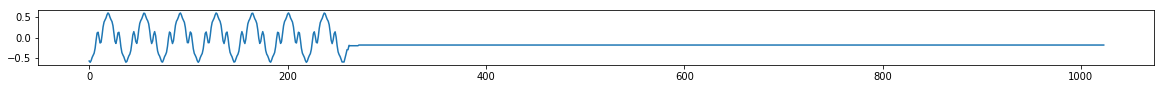

2018-11-13 12:47:16 Epoch [1/1], Step [105/4875] Loss: 3.7232
2018-11-13 12:47:26 Epoch [1/1], Step [110/4875] Loss: 3.6778
2018-11-13 12:47:36 Epoch [1/1], Step [115/4875] Loss: 3.5831
2018-11-13 12:47:46 Epoch [1/1], Step [120/4875] Loss: 3.6321
2018-11-13 12:47:56 Epoch [1/1], Step [125/4875] Loss: 3.9295
2018-11-13 12:48:06 Epoch [1/1], Step [130/4875] Loss: 3.6694
2018-11-13 12:48:16 Epoch [1/1], Step [135/4875] Loss: 3.6192
2018-11-13 12:48:26 Epoch [1/1], Step [140/4875] Loss: 3.4805
2018-11-13 12:48:36 Epoch [1/1], Step [145/4875] Loss: 3.3595
2018-11-13 12:48:46 Epoch [1/1], Step [150/4875] Loss: 3.3596
2018-11-13 12:48:56 Epoch [1/1], Step [155/4875] Loss: 3.3075
2018-11-13 12:49:05 Epoch [1/1], Step [160/4875] Loss: 3.2272
2018-11-13 12:49:15 Epoch [1/1], Step [165/4875] Loss: 3.2190
2018-11-13 12:49:25 Epoch [1/1], Step [170/4875] Loss: 3.2231
2018-11-13 12:49:35 Epoch [1/1], Step [175/4875] Loss: 3.1539
2018-11-13 12:49:45 Epoch [1/1], Step [180/4875] Loss: 3.1724
2018-11-

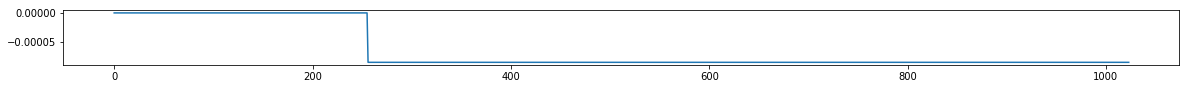

2018-11-13 12:50:36 Epoch [1/1], Step [205/4875] Loss: 2.9838
2018-11-13 12:50:45 Epoch [1/1], Step [210/4875] Loss: 2.9806
2018-11-13 12:50:55 Epoch [1/1], Step [215/4875] Loss: 2.9782
2018-11-13 12:51:05 Epoch [1/1], Step [220/4875] Loss: 2.9550
2018-11-13 12:51:15 Epoch [1/1], Step [225/4875] Loss: 2.9141
2018-11-13 12:51:25 Epoch [1/1], Step [230/4875] Loss: 2.8978
2018-11-13 12:51:35 Epoch [1/1], Step [235/4875] Loss: 2.8336
2018-11-13 12:51:44 Epoch [1/1], Step [240/4875] Loss: 2.8807
2018-11-13 12:51:54 Epoch [1/1], Step [245/4875] Loss: 2.8098
2018-11-13 12:52:04 Epoch [1/1], Step [250/4875] Loss: 2.7903
2018-11-13 12:52:14 Epoch [1/1], Step [255/4875] Loss: 2.8191
2018-11-13 12:52:23 Epoch [1/1], Step [260/4875] Loss: 2.7841
2018-11-13 12:52:33 Epoch [1/1], Step [265/4875] Loss: 2.7905
2018-11-13 12:52:43 Epoch [1/1], Step [270/4875] Loss: 2.7957
2018-11-13 12:52:53 Epoch [1/1], Step [275/4875] Loss: 2.7088
2018-11-13 12:53:03 Epoch [1/1], Step [280/4875] Loss: 2.7112
2018-11-

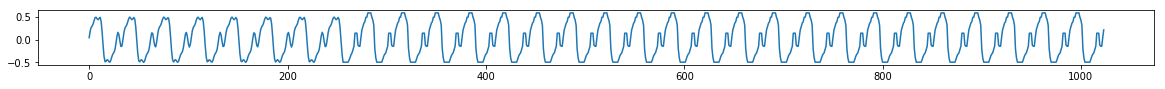

2018-11-13 12:53:53 Epoch [1/1], Step [305/4875] Loss: 2.6620
2018-11-13 12:54:03 Epoch [1/1], Step [310/4875] Loss: 2.6520
2018-11-13 12:54:13 Epoch [1/1], Step [315/4875] Loss: 2.6189
2018-11-13 12:54:22 Epoch [1/1], Step [320/4875] Loss: 2.5727
2018-11-13 12:54:32 Epoch [1/1], Step [325/4875] Loss: 2.5823
2018-11-13 12:54:42 Epoch [1/1], Step [330/4875] Loss: 2.6104
2018-11-13 12:54:52 Epoch [1/1], Step [335/4875] Loss: 2.5810
2018-11-13 12:55:01 Epoch [1/1], Step [340/4875] Loss: 2.5947
2018-11-13 12:55:11 Epoch [1/1], Step [345/4875] Loss: 2.5608
2018-11-13 12:55:21 Epoch [1/1], Step [350/4875] Loss: 2.5094
2018-11-13 12:55:31 Epoch [1/1], Step [355/4875] Loss: 2.5930
2018-11-13 12:55:41 Epoch [1/1], Step [360/4875] Loss: 2.6004
2018-11-13 12:55:50 Epoch [1/1], Step [365/4875] Loss: 2.6549
2018-11-13 12:56:00 Epoch [1/1], Step [370/4875] Loss: 2.6197
2018-11-13 12:56:10 Epoch [1/1], Step [375/4875] Loss: 2.5360
2018-11-13 12:56:19 Epoch [1/1], Step [380/4875] Loss: 2.4241
2018-11-

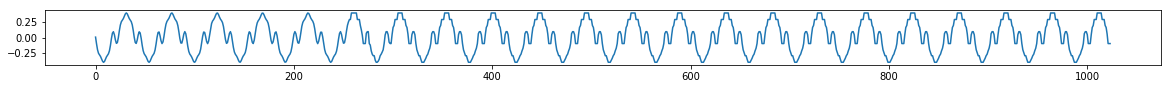

2018-11-13 12:57:09 Epoch [1/1], Step [405/4875] Loss: 2.4758
2018-11-13 12:57:19 Epoch [1/1], Step [410/4875] Loss: 2.4527
2018-11-13 12:57:29 Epoch [1/1], Step [415/4875] Loss: 2.4107
2018-11-13 12:57:38 Epoch [1/1], Step [420/4875] Loss: 2.4416
2018-11-13 12:57:48 Epoch [1/1], Step [425/4875] Loss: 2.3680
2018-11-13 12:57:58 Epoch [1/1], Step [430/4875] Loss: 2.3985
2018-11-13 12:58:07 Epoch [1/1], Step [435/4875] Loss: 2.3691
2018-11-13 12:58:17 Epoch [1/1], Step [440/4875] Loss: 2.4381
2018-11-13 12:58:27 Epoch [1/1], Step [445/4875] Loss: 2.3904
2018-11-13 12:58:36 Epoch [1/1], Step [450/4875] Loss: 2.4243
2018-11-13 12:58:46 Epoch [1/1], Step [455/4875] Loss: 2.3538
2018-11-13 12:58:56 Epoch [1/1], Step [460/4875] Loss: 2.3098
2018-11-13 12:59:05 Epoch [1/1], Step [465/4875] Loss: 2.3268
2018-11-13 12:59:15 Epoch [1/1], Step [470/4875] Loss: 2.3253
2018-11-13 12:59:25 Epoch [1/1], Step [475/4875] Loss: 2.4284
2018-11-13 12:59:35 Epoch [1/1], Step [480/4875] Loss: 2.3875
2018-11-

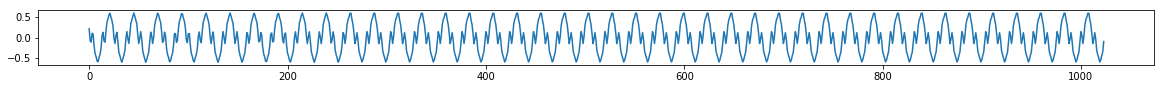

2018-11-13 13:00:25 Epoch [1/1], Step [505/4875] Loss: 2.4039
2018-11-13 13:00:34 Epoch [1/1], Step [510/4875] Loss: 2.3804
2018-11-13 13:00:44 Epoch [1/1], Step [515/4875] Loss: 2.3579
2018-11-13 13:00:54 Epoch [1/1], Step [520/4875] Loss: 2.2966
2018-11-13 13:01:04 Epoch [1/1], Step [525/4875] Loss: 2.2713
2018-11-13 13:01:13 Epoch [1/1], Step [530/4875] Loss: 2.2655
2018-11-13 13:01:23 Epoch [1/1], Step [535/4875] Loss: 2.2386
2018-11-13 13:01:32 Epoch [1/1], Step [540/4875] Loss: 2.2604
2018-11-13 13:01:42 Epoch [1/1], Step [545/4875] Loss: 2.2455
2018-11-13 13:01:52 Epoch [1/1], Step [550/4875] Loss: 2.2170
2018-11-13 13:02:01 Epoch [1/1], Step [555/4875] Loss: 2.3347
2018-11-13 13:02:11 Epoch [1/1], Step [560/4875] Loss: 2.2898
2018-11-13 13:02:21 Epoch [1/1], Step [565/4875] Loss: 2.2512
2018-11-13 13:02:30 Epoch [1/1], Step [570/4875] Loss: 2.2691
2018-11-13 13:02:40 Epoch [1/1], Step [575/4875] Loss: 2.3031
2018-11-13 13:02:49 Epoch [1/1], Step [580/4875] Loss: 2.2142
2018-11-

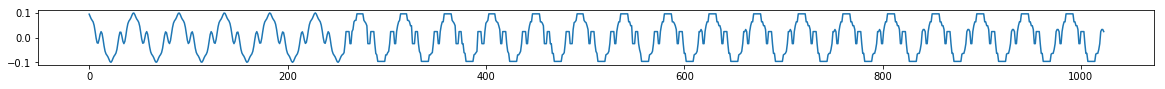

2018-11-13 13:03:40 Epoch [1/1], Step [605/4875] Loss: 2.2464
2018-11-13 13:03:49 Epoch [1/1], Step [610/4875] Loss: 2.1995
2018-11-13 13:03:59 Epoch [1/1], Step [615/4875] Loss: 2.1592
2018-11-13 13:04:09 Epoch [1/1], Step [620/4875] Loss: 2.2446
2018-11-13 13:04:18 Epoch [1/1], Step [625/4875] Loss: 2.2019
2018-11-13 13:04:28 Epoch [1/1], Step [630/4875] Loss: 2.2265
2018-11-13 13:04:37 Epoch [1/1], Step [635/4875] Loss: 2.2219
2018-11-13 13:04:47 Epoch [1/1], Step [640/4875] Loss: 2.1752
2018-11-13 13:04:57 Epoch [1/1], Step [645/4875] Loss: 2.1469
2018-11-13 13:05:07 Epoch [1/1], Step [650/4875] Loss: 2.1285
2018-11-13 13:05:16 Epoch [1/1], Step [655/4875] Loss: 2.1094
2018-11-13 13:05:26 Epoch [1/1], Step [660/4875] Loss: 2.2831
2018-11-13 13:05:35 Epoch [1/1], Step [665/4875] Loss: 2.2333
2018-11-13 13:05:45 Epoch [1/1], Step [670/4875] Loss: 2.1771
2018-11-13 13:05:55 Epoch [1/1], Step [675/4875] Loss: 2.1733
2018-11-13 13:06:04 Epoch [1/1], Step [680/4875] Loss: 2.2070
2018-11-

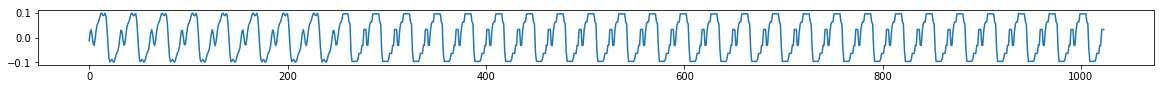

2018-11-13 13:06:54 Epoch [1/1], Step [705/4875] Loss: 2.1447
2018-11-13 13:07:04 Epoch [1/1], Step [710/4875] Loss: 2.0983
2018-11-13 13:07:13 Epoch [1/1], Step [715/4875] Loss: 2.2910
2018-11-13 13:07:23 Epoch [1/1], Step [720/4875] Loss: 2.2437
2018-11-13 13:07:33 Epoch [1/1], Step [725/4875] Loss: 2.1353
2018-11-13 13:07:42 Epoch [1/1], Step [730/4875] Loss: 2.1230
2018-11-13 13:07:52 Epoch [1/1], Step [735/4875] Loss: 2.1238
2018-11-13 13:08:02 Epoch [1/1], Step [740/4875] Loss: 2.1030
2018-11-13 13:08:11 Epoch [1/1], Step [745/4875] Loss: 2.1163
2018-11-13 13:08:21 Epoch [1/1], Step [750/4875] Loss: 2.1667
2018-11-13 13:08:31 Epoch [1/1], Step [755/4875] Loss: 2.1621
2018-11-13 13:08:40 Epoch [1/1], Step [760/4875] Loss: 2.1229
2018-11-13 13:08:50 Epoch [1/1], Step [765/4875] Loss: 2.1299
2018-11-13 13:09:00 Epoch [1/1], Step [770/4875] Loss: 2.0770
2018-11-13 13:09:09 Epoch [1/1], Step [775/4875] Loss: 2.1066
2018-11-13 13:09:19 Epoch [1/1], Step [780/4875] Loss: 2.1304
2018-11-

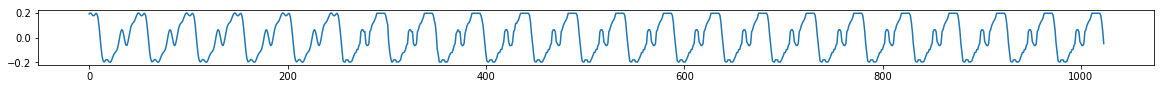

2018-11-13 13:10:09 Epoch [1/1], Step [805/4875] Loss: 2.0884
2018-11-13 13:10:19 Epoch [1/1], Step [810/4875] Loss: 2.0580
2018-11-13 13:10:28 Epoch [1/1], Step [815/4875] Loss: 2.0317
2018-11-13 13:10:38 Epoch [1/1], Step [820/4875] Loss: 2.0247
2018-11-13 13:10:48 Epoch [1/1], Step [825/4875] Loss: 2.1045
2018-11-13 13:10:58 Epoch [1/1], Step [830/4875] Loss: 2.1224
2018-11-13 13:11:07 Epoch [1/1], Step [835/4875] Loss: 2.1157
2018-11-13 13:11:17 Epoch [1/1], Step [840/4875] Loss: 2.0869
2018-11-13 13:11:26 Epoch [1/1], Step [845/4875] Loss: 2.0281
2018-11-13 13:11:36 Epoch [1/1], Step [850/4875] Loss: 2.1378
2018-11-13 13:11:46 Epoch [1/1], Step [855/4875] Loss: 2.0441
2018-11-13 13:11:56 Epoch [1/1], Step [860/4875] Loss: 2.0443
2018-11-13 13:12:05 Epoch [1/1], Step [865/4875] Loss: 2.0729
2018-11-13 13:12:15 Epoch [1/1], Step [870/4875] Loss: 2.0895
2018-11-13 13:12:25 Epoch [1/1], Step [875/4875] Loss: 2.1060
2018-11-13 13:12:34 Epoch [1/1], Step [880/4875] Loss: 2.0132
2018-11-

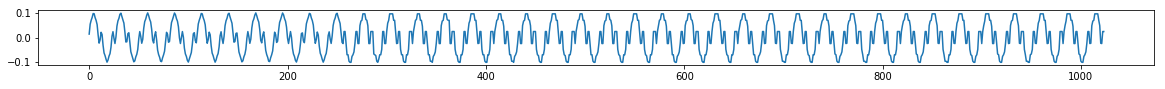

2018-11-13 13:13:24 Epoch [1/1], Step [905/4875] Loss: 2.0631
2018-11-13 13:13:34 Epoch [1/1], Step [910/4875] Loss: 1.9832
2018-11-13 13:13:44 Epoch [1/1], Step [915/4875] Loss: 2.0169
2018-11-13 13:13:53 Epoch [1/1], Step [920/4875] Loss: 1.9836
2018-11-13 13:14:03 Epoch [1/1], Step [925/4875] Loss: 2.0285
2018-11-13 13:14:12 Epoch [1/1], Step [930/4875] Loss: 2.0078
2018-11-13 13:14:22 Epoch [1/1], Step [935/4875] Loss: 2.0202
2018-11-13 13:14:32 Epoch [1/1], Step [940/4875] Loss: 2.1593
2018-11-13 13:14:42 Epoch [1/1], Step [945/4875] Loss: 2.0676
2018-11-13 13:14:51 Epoch [1/1], Step [950/4875] Loss: 2.0300
2018-11-13 13:15:01 Epoch [1/1], Step [955/4875] Loss: 1.9982
2018-11-13 13:15:10 Epoch [1/1], Step [960/4875] Loss: 1.9792
2018-11-13 13:15:20 Epoch [1/1], Step [965/4875] Loss: 1.9355
2018-11-13 13:15:30 Epoch [1/1], Step [970/4875] Loss: 1.9646
2018-11-13 13:15:40 Epoch [1/1], Step [975/4875] Loss: 2.0011
2018-11-13 13:15:49 Epoch [1/1], Step [980/4875] Loss: 2.2498
2018-11-

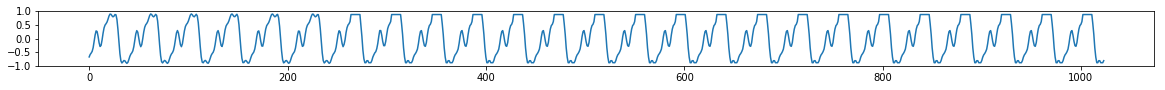

Training time taken: 0:32:46
model saved at epoch1


In [12]:
# Train!
#*************************************
list_of_losses = []

print('{:%Y-%m-%d %H:%M:%S} Starting training...'.format(datetime.now()))
start_time = time.monotonic()
for epoch in range(num_epochs):
    train(rnn,epoch)
elapsed_time = time.monotonic() - start_time
print('Training time taken:',time_taken(elapsed_time))

if savemodel_interval == 0 and savemodel:
    torch.save(rnn.state_dict(), 
       '{}/{:%Y-%m-%d_%H-%M-%S}_model_epoch{}.pth'.format(savemodeldir,datetime.now(),num_epochs))
    print('model saved at epoch{}'.format(num_epochs))

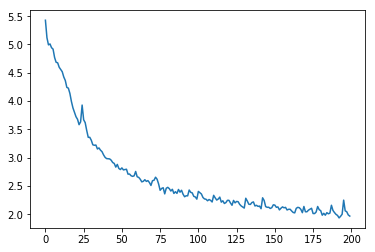

In [13]:
# Plot the loss over time
#*************************************
plt.figure()
plt.plot(list_of_losses)